# LSTM - vanilla

In [1]:
best_model = "best_model14.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


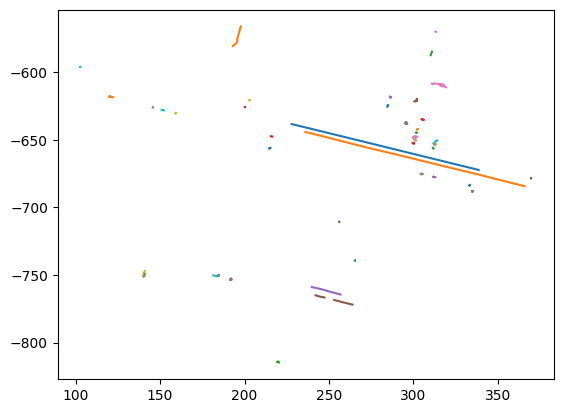

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [7]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [8]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [24]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :5]  # Use position + velocity
        x = x.reshape(-1, 50, 50, 5)[:, 0, :, :]  # (batch, 50, 5), ego only
        
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, 2) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [22]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [21]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [22]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [23]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_36239/2425023728.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_36239/2425023728.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/100 [00:18<29:56, 18.15s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 0.8196 | Val MSE 9.9922 | Val MAE 14.2046 | Val MSE 489.6186
Sample pred first 3 steps: [[-0.0718951   0.04398853]
 [-0.10230919  0.06296059]
 [-0.15777715  0.07428043]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 9.992216


Epoch:   2%|▏         | 2/100 [00:35<29:17, 17.93s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.0254 | Val MSE 11.4765 | Val MAE 15.7512 | Val MSE 562.3474


Epoch:   3%|▎         | 3/100 [00:53<29:02, 17.96s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.0009 | Val MSE 3.5812 | Val MAE 8.5068 | Val MSE 175.4802
Validation improved: 9.992216 -> 3.581230


Epoch:   4%|▍         | 4/100 [01:11<28:34, 17.86s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.0002 | Val MSE 1.5754 | Val MAE 5.9034 | Val MSE 77.1970
Validation improved: 3.581230 -> 1.575449


Epoch:   5%|▌         | 5/100 [01:28<27:58, 17.66s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.0025 | Val MSE 5.9807 | Val MAE 9.7893 | Val MSE 293.0543


Epoch:   6%|▌         | 6/100 [01:46<27:30, 17.56s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.0004 | Val MSE 4.5416 | Val MAE 8.4041 | Val MSE 222.5374
Sample pred first 3 steps: [[ 0.01263717 -0.00051657]
 [-0.00077995  0.02224584]
 [ 0.0413419   0.04084098]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [02:03<27:11, 17.54s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.0020 | Val MSE 33.1298 | Val MAE 26.2718 | Val MSE 1623.3581


Epoch:   8%|▊         | 8/100 [02:21<26:57, 17.58s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.0047 | Val MSE 29.8564 | Val MAE 24.2493 | Val MSE 1462.9642


Epoch:   9%|▉         | 9/100 [02:38<26:37, 17.55s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.0030 | Val MSE 1.8298 | Val MAE 5.8148 | Val MSE 89.6612


Epoch:  10%|█         | 10/100 [02:56<26:12, 17.48s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.0001 | Val MSE 1.4930 | Val MAE 4.9411 | Val MSE 73.1549
Validation improved: 1.575449 -> 1.492958


Epoch:  11%|█         | 11/100 [03:13<25:51, 17.44s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.0003 | Val MSE 3.7060 | Val MAE 7.9218 | Val MSE 181.5953
Sample pred first 3 steps: [[-0.02618653  0.00369637]
 [-0.02835346  0.01186895]
 [-0.05971552  0.02991204]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  12%|█▏        | 12/100 [03:48<33:13, 22.66s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.0002 | Val MSE 1.3260 | Val MAE 4.4889 | Val MSE 64.9746
Validation improved: 1.492958 -> 1.326012


Epoch:  13%|█▎        | 13/100 [04:05<30:34, 21.09s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.0004 | Val MSE 1.3219 | Val MAE 4.5021 | Val MSE 64.7707
Validation improved: 1.326012 -> 1.321851


Epoch:  14%|█▍        | 14/100 [04:23<28:49, 20.11s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.0012 | Val MSE 10.2055 | Val MAE 14.6776 | Val MSE 500.0717


Epoch:  15%|█▌        | 15/100 [04:41<27:25, 19.36s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.0013 | Val MSE 4.3220 | Val MAE 8.5685 | Val MSE 211.7757


Epoch:  16%|█▌        | 16/100 [04:58<26:13, 18.74s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.0042 | Val MSE 2.4896 | Val MAE 6.3457 | Val MSE 121.9928
Sample pred first 3 steps: [[-0.00362361 -0.0070461 ]
 [-0.01687053 -0.01908521]
 [-0.03325962 -0.03368102]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [05:15<25:16, 18.28s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.0003 | Val MSE 1.7836 | Val MAE 6.0609 | Val MSE 87.3972


Epoch:  18%|█▊        | 18/100 [05:34<25:05, 18.36s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.0005 | Val MSE 3.6035 | Val MAE 7.0914 | Val MSE 176.5718


Epoch:  19%|█▉        | 19/100 [05:53<25:02, 18.55s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.0056 | Val MSE 2.1645 | Val MAE 6.3068 | Val MSE 106.0617


Epoch:  20%|██        | 20/100 [06:10<24:21, 18.27s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.0003 | Val MSE 0.7336 | Val MAE 3.2188 | Val MSE 35.9478
Validation improved: 1.321851 -> 0.733628


Epoch:  21%|██        | 21/100 [06:28<23:38, 17.95s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.0004 | Val MSE 1.8870 | Val MAE 4.9719 | Val MSE 92.4606
Sample pred first 3 steps: [[ 0.00091591 -0.0037553 ]
 [ 0.00167079 -0.00636551]
 [ 0.00257285 -0.00358195]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [06:45<23:03, 17.74s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.0003 | Val MSE 1.6589 | Val MAE 5.0271 | Val MSE 81.2876


Epoch:  23%|██▎       | 23/100 [07:02<22:32, 17.57s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.0008 | Val MSE 9.9086 | Val MAE 13.1119 | Val MSE 485.5219


Epoch:  24%|██▍       | 24/100 [07:19<22:05, 17.44s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.0026 | Val MSE 1.1025 | Val MAE 4.5765 | Val MSE 54.0219


Epoch:  25%|██▌       | 25/100 [07:36<21:45, 17.41s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.0016 | Val MSE 1.6506 | Val MAE 5.0296 | Val MSE 80.8808


Epoch:  26%|██▌       | 26/100 [07:54<21:22, 17.33s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.0005 | Val MSE 1.4555 | Val MAE 5.4447 | Val MSE 71.3212
Sample pred first 3 steps: [[ 0.01372853  0.00348483]
 [ 0.02257523 -0.01663537]
 [ 0.04967353 -0.03191414]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [08:11<21:07, 17.36s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.0022 | Val MSE 1.6192 | Val MAE 5.5979 | Val MSE 79.3423


Epoch:  28%|██▊       | 28/100 [08:29<20:57, 17.46s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.0014 | Val MSE 7.3625 | Val MAE 12.4970 | Val MSE 360.7647


Epoch:  29%|██▉       | 29/100 [08:46<20:34, 17.38s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.0028 | Val MSE 3.7081 | Val MAE 7.9253 | Val MSE 181.6988


Epoch:  30%|███       | 30/100 [09:02<19:53, 17.05s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.0022 | Val MSE 6.9519 | Val MAE 9.8055 | Val MSE 340.6453


Epoch:  31%|███       | 31/100 [09:17<18:59, 16.51s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.0076 | Val MSE 0.5919 | Val MAE 3.1127 | Val MSE 29.0031
Sample pred first 3 steps: [[-0.00283753  0.00549819]
 [ 0.00270076 -0.0022848 ]
 [ 0.01027548 -0.00527777]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.733628 -> 0.591900


Epoch:  32%|███▏      | 32/100 [09:32<18:11, 16.05s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.0009 | Val MSE 0.5815 | Val MAE 3.2609 | Val MSE 28.4926
Validation improved: 0.591900 -> 0.581482


Epoch:  33%|███▎      | 33/100 [09:47<17:32, 15.71s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.0016 | Val MSE 1.2442 | Val MAE 4.6252 | Val MSE 60.9652


Epoch:  34%|███▍      | 34/100 [10:02<17:00, 15.47s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.0021 | Val MSE 1.4353 | Val MAE 5.3891 | Val MSE 70.3309


Epoch:  35%|███▌      | 35/100 [10:17<16:33, 15.29s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.0016 | Val MSE 0.7808 | Val MAE 3.8472 | Val MSE 38.2582


Epoch:  36%|███▌      | 36/100 [10:32<16:11, 15.19s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.0061 | Val MSE 4.0121 | Val MAE 7.8581 | Val MSE 196.5938
Sample pred first 3 steps: [[ 0.00023239  0.00973888]
 [ 0.0006681   0.00371622]
 [-0.02088071 -0.01150791]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [10:47<15:49, 15.07s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.0070 | Val MSE 0.6534 | Val MAE 3.1341 | Val MSE 32.0160


Epoch:  38%|███▊      | 38/100 [11:02<15:30, 15.01s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.0014 | Val MSE 0.4283 | Val MAE 2.4472 | Val MSE 20.9844
Validation improved: 0.581482 -> 0.428254


Epoch:  39%|███▉      | 39/100 [11:16<15:01, 14.78s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.0153 | Val MSE 0.6821 | Val MAE 3.1769 | Val MSE 33.4217


Epoch:  40%|████      | 40/100 [11:30<14:37, 14.63s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.0061 | Val MSE 0.5842 | Val MAE 2.6874 | Val MSE 28.6267


Epoch:  41%|████      | 41/100 [11:45<14:17, 14.54s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.0137 | Val MSE 1.4626 | Val MAE 5.4582 | Val MSE 71.6689
Sample pred first 3 steps: [[-0.00985987 -0.00749688]
 [-0.00856727 -0.00622812]
 [-0.01880124 -0.0129041 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [12:00<14:24, 14.90s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.0151 | Val MSE 2.1176 | Val MAE 5.8677 | Val MSE 103.7623


Epoch:  43%|████▎     | 43/100 [12:15<14:08, 14.88s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.0080 | Val MSE 0.4589 | Val MAE 2.6758 | Val MSE 22.4880


Epoch:  44%|████▍     | 44/100 [12:30<13:50, 14.82s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.0424 | Val MSE 0.7513 | Val MAE 3.5784 | Val MSE 36.8117


Epoch:  45%|████▌     | 45/100 [12:45<13:42, 14.95s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.0425 | Val MSE 0.6089 | Val MAE 3.0116 | Val MSE 29.8348


Epoch:  46%|████▌     | 46/100 [13:01<13:40, 15.20s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.0756 | Val MSE 0.6292 | Val MAE 3.1214 | Val MSE 30.8318
Sample pred first 3 steps: [[ 0.00377483 -0.00323125]
 [ 0.0007752  -0.00132729]
 [-0.00101924  0.00542174]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [13:17<13:37, 15.43s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.0445 | Val MSE 0.3720 | Val MAE 2.1637 | Val MSE 18.2259
Validation improved: 0.428254 -> 0.371958


Epoch:  48%|████▊     | 48/100 [13:32<13:17, 15.33s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1173 | Val MSE 0.4635 | Val MAE 2.5562 | Val MSE 22.7093


Epoch:  49%|████▉     | 49/100 [13:47<12:52, 15.14s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.2134 | Val MSE 0.4424 | Val MAE 2.3399 | Val MSE 21.6772


Epoch:  50%|█████     | 50/100 [14:01<12:29, 14.99s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.2993 | Val MSE 0.5228 | Val MAE 2.7196 | Val MSE 25.6151


Epoch:  51%|█████     | 51/100 [14:16<12:09, 14.88s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.5404 | Val MSE 0.4120 | Val MAE 2.5099 | Val MSE 20.1899
Sample pred first 3 steps: [[-0.02215626  0.00599189]
 [-0.01779971  0.00656336]
 [-0.00252126  0.01050247]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [14:31<11:50, 14.81s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.3835 | Val MSE 0.3459 | Val MAE 2.1872 | Val MSE 16.9492
Validation improved: 0.371958 -> 0.345903


Epoch:  53%|█████▎    | 53/100 [14:45<11:37, 14.85s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.3379 | Val MSE 0.3223 | Val MAE 2.0423 | Val MSE 15.7907
Validation improved: 0.345903 -> 0.322259


Epoch:  54%|█████▍    | 54/100 [15:01<11:26, 14.93s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.3227 | Val MSE 0.3037 | Val MAE 1.9919 | Val MSE 14.8792
Validation improved: 0.322259 -> 0.303657


Epoch:  55%|█████▌    | 55/100 [15:16<11:24, 15.22s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.3061 | Val MSE 0.2822 | Val MAE 1.9393 | Val MSE 13.8276
Validation improved: 0.303657 -> 0.282196


Epoch:  56%|█████▌    | 56/100 [15:32<11:07, 15.18s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.2890 | Val MSE 0.3172 | Val MAE 2.0312 | Val MSE 15.5444
Sample pred first 3 steps: [[-0.01173007  0.00476076]
 [ 0.00430884 -0.00215281]
 [ 0.01269537 -0.00165564]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  57%|█████▋    | 57/100 [15:46<10:45, 15.01s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.2803 | Val MSE 0.2812 | Val MAE 1.9779 | Val MSE 13.7786
Validation improved: 0.282196 -> 0.281195


Epoch:  58%|█████▊    | 58/100 [16:01<10:30, 15.02s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.2719 | Val MSE 0.2606 | Val MAE 1.7764 | Val MSE 12.7705
Validation improved: 0.281195 -> 0.260622


Epoch:  59%|█████▉    | 59/100 [16:17<10:20, 15.15s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.2608 | Val MSE 0.2582 | Val MAE 1.8270 | Val MSE 12.6536
Validation improved: 0.260622 -> 0.258237


Epoch:  60%|██████    | 60/100 [16:31<09:59, 14.98s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.2548 | Val MSE 0.2668 | Val MAE 1.9960 | Val MSE 13.0719


Epoch:  61%|██████    | 61/100 [16:46<09:36, 14.79s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.2491 | Val MSE 0.2354 | Val MAE 1.7252 | Val MSE 11.5351
Sample pred first 3 steps: [[-0.00612266  0.01162862]
 [ 0.001677   -0.00156065]
 [ 0.01679495 -0.01929476]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.258237 -> 0.235411


Epoch:  62%|██████▏   | 62/100 [17:00<09:17, 14.67s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.2477 | Val MSE 0.2398 | Val MAE 1.7099 | Val MSE 11.7496


Epoch:  63%|██████▎   | 63/100 [17:14<08:58, 14.56s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.2450 | Val MSE 0.2734 | Val MAE 1.9545 | Val MSE 13.3981


Epoch:  64%|██████▍   | 64/100 [17:29<08:44, 14.58s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.2375 | Val MSE 0.2352 | Val MAE 1.7627 | Val MSE 11.5270
Validation improved: 0.235411 -> 0.235245


Epoch:  65%|██████▌   | 65/100 [17:44<08:38, 14.81s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.2347 | Val MSE 0.2233 | Val MAE 1.5652 | Val MSE 10.9415
Validation improved: 0.235245 -> 0.223297


Epoch:  66%|██████▌   | 66/100 [18:49<16:57, 29.94s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.2315 | Val MSE 0.2258 | Val MAE 1.6368 | Val MSE 11.0628
Sample pred first 3 steps: [[ 0.00061681  0.01047336]
 [ 0.00407044 -0.00595302]
 [ 0.02243225 -0.00754274]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [19:41<19:59, 36.35s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.2279 | Val MSE 0.2190 | Val MAE 1.6699 | Val MSE 10.7326
Validation improved: 0.223297 -> 0.219033


Epoch:  68%|██████▊   | 68/100 [19:55<15:53, 29.81s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.2233 | Val MSE 0.2146 | Val MAE 1.6182 | Val MSE 10.5174
Validation improved: 0.219033 -> 0.214641


Epoch:  69%|██████▉   | 69/100 [20:10<13:02, 25.26s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.2176 | Val MSE 0.2084 | Val MAE 1.5743 | Val MSE 10.2103
Validation improved: 0.214641 -> 0.208373


Epoch:  70%|███████   | 70/100 [20:25<11:03, 22.13s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.2200 | Val MSE 0.2125 | Val MAE 1.6745 | Val MSE 10.4144


Epoch:  71%|███████   | 71/100 [20:40<09:38, 19.96s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.2194 | Val MSE 0.2189 | Val MAE 1.6402 | Val MSE 10.7245
Sample pred first 3 steps: [[-0.00636791  0.00071825]
 [-0.00825751 -0.00259419]
 [-0.00857692  0.00709706]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [20:54<08:34, 18.36s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.2160 | Val MSE 0.2201 | Val MAE 1.6490 | Val MSE 10.7833


Epoch:  73%|███████▎  | 73/100 [21:09<07:43, 17.17s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.2168 | Val MSE 0.2065 | Val MAE 1.5868 | Val MSE 10.1201
Validation improved: 0.208373 -> 0.206533


Epoch:  74%|███████▍  | 74/100 [21:24<07:08, 16.47s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.2110 | Val MSE 0.2013 | Val MAE 1.5561 | Val MSE 9.8658
Validation improved: 0.206533 -> 0.201343


Epoch:  75%|███████▌  | 75/100 [21:38<06:39, 16.00s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.2131 | Val MSE 0.2010 | Val MAE 1.5192 | Val MSE 9.8473
Validation improved: 0.201343 -> 0.200966


Epoch:  76%|███████▌  | 76/100 [21:53<06:12, 15.53s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.2074 | Val MSE 0.2017 | Val MAE 1.5327 | Val MSE 9.8839
Sample pred first 3 steps: [[-0.0018997   0.01393134]
 [-0.00041861  0.00045135]
 [ 0.01829001  0.00165817]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [22:07<05:50, 15.23s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.2069 | Val MSE 0.2175 | Val MAE 1.7658 | Val MSE 10.6587


Epoch:  78%|███████▊  | 78/100 [22:23<05:36, 15.28s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.2069 | Val MSE 0.1959 | Val MAE 1.4799 | Val MSE 9.6006
Validation improved: 0.200966 -> 0.195932


Epoch:  79%|███████▉  | 79/100 [22:38<05:17, 15.13s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.2055 | Val MSE 0.1974 | Val MAE 1.4990 | Val MSE 9.6722


Epoch:  80%|████████  | 80/100 [22:53<05:01, 15.07s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.2049 | Val MSE 0.2033 | Val MAE 1.5955 | Val MSE 9.9637


Epoch:  81%|████████  | 81/100 [23:08<04:48, 15.20s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.2003 | Val MSE 0.1963 | Val MAE 1.5077 | Val MSE 9.6208
Sample pred first 3 steps: [[-0.0022492   0.01810633]
 [-0.00648953  0.0074232 ]
 [ 0.00122742  0.00616866]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [23:23<04:33, 15.20s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.2010 | Val MSE 0.2041 | Val MAE 1.5248 | Val MSE 10.0010


Epoch:  83%|████████▎ | 83/100 [23:38<04:16, 15.08s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.1985 | Val MSE 0.2017 | Val MAE 1.5628 | Val MSE 9.8822


Epoch:  84%|████████▍ | 84/100 [23:54<04:04, 15.25s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.1994 | Val MSE 0.1982 | Val MAE 1.5190 | Val MSE 9.7133


Epoch:  85%|████████▌ | 85/100 [24:09<03:46, 15.13s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.1989 | Val MSE 0.1941 | Val MAE 1.4814 | Val MSE 9.5119
Validation improved: 0.195932 -> 0.194120


Epoch:  86%|████████▌ | 86/100 [24:23<03:30, 15.03s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.1965 | Val MSE 0.1925 | Val MAE 1.4479 | Val MSE 9.4311
Sample pred first 3 steps: [[-0.00437902  0.01652651]
 [-0.0090647   0.00839883]
 [ 0.00016806  0.00413497]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.194120 -> 0.192473


Epoch:  87%|████████▋ | 87/100 [24:38<03:14, 14.93s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.1972 | Val MSE 0.1942 | Val MAE 1.4854 | Val MSE 9.5147


Epoch:  88%|████████▊ | 88/100 [24:53<02:59, 14.98s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.1955 | Val MSE 0.1995 | Val MAE 1.5637 | Val MSE 9.7772


Epoch:  89%|████████▉ | 89/100 [25:08<02:45, 15.07s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.1931 | Val MSE 0.1915 | Val MAE 1.4767 | Val MSE 9.3823
Validation improved: 0.192473 -> 0.191477


Epoch:  90%|█████████ | 90/100 [25:23<02:30, 15.05s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.1926 | Val MSE 0.1905 | Val MAE 1.5129 | Val MSE 9.3352
Validation improved: 0.191477 -> 0.190515


Epoch:  91%|█████████ | 91/100 [25:38<02:13, 14.81s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.1933 | Val MSE 0.1914 | Val MAE 1.4756 | Val MSE 9.3795
Sample pred first 3 steps: [[-0.00474864  0.01023892]
 [-0.00817875  0.0095375 ]
 [-0.00634696  0.00672149]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [25:52<01:58, 14.77s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.1935 | Val MSE 0.1883 | Val MAE 1.4650 | Val MSE 9.2286
Validation improved: 0.190515 -> 0.188339


Epoch:  93%|█████████▎| 93/100 [26:07<01:43, 14.80s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.1933 | Val MSE 0.1893 | Val MAE 1.4752 | Val MSE 9.2754


Epoch:  94%|█████████▍| 94/100 [26:22<01:28, 14.70s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.1914 | Val MSE 0.1868 | Val MAE 1.4622 | Val MSE 9.1534
Validation improved: 0.188339 -> 0.186803


Epoch:  95%|█████████▌| 95/100 [26:36<01:12, 14.56s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.1920 | Val MSE 0.1872 | Val MAE 1.4741 | Val MSE 9.1735


Epoch:  96%|█████████▌| 96/100 [26:50<00:58, 14.54s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.1909 | Val MSE 0.1882 | Val MAE 1.4489 | Val MSE 9.2202
Sample pred first 3 steps: [[-0.00238459  0.00447339]
 [-0.00335112  0.00557549]
 [-0.00167468  0.00315861]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [27:06<00:44, 14.72s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.1875 | Val MSE 0.1887 | Val MAE 1.4523 | Val MSE 9.2487


Epoch:  98%|█████████▊| 98/100 [27:20<00:29, 14.77s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.1892 | Val MSE 0.1834 | Val MAE 1.4261 | Val MSE 8.9850
Validation improved: 0.186803 -> 0.183368


Epoch:  99%|█████████▉| 99/100 [27:35<00:14, 14.77s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.1903 | Val MSE 0.1833 | Val MAE 1.4275 | Val MSE 8.9813
Validation improved: 0.183368 -> 0.183292


Epoch: 100%|██████████| 100/100 [27:50<00:00, 16.71s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.1893 | Val MSE 0.1887 | Val MAE 1.5091 | Val MSE 9.2481
Val MSE: 8.9813


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, batch_first=True)
  (decoder): LSTM(2, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)

# Final Pred

In [25]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto14.csv', index=True)